# Overview
This script creates plots that were used in Traditional poster at ISMRM 2025 (Hannum et al,)
The script generates waveforms that are pulsed-gradient spin-echo (PGSE), that are referred in the code as "Trap" waveforms. IT then generates optimized waveforms from the GrOpt toolbox. Results are saved out as SVG files.

In [9]:
import numpy as np
import sys
sys.path.append("utils/")
from trap_waveforms import *

sys.path.append("utils/gropt/python")
import gropt
from helper_utils import *

from matplotlib import pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns

# Example 1: System with Gmax = 45 mT/m and Smax = 200 T/m/s, M0 moment nulling

In [10]:
# Demo for 45/200 System
# 1. Load the system parameters
gmax = 38 #Cannot actually reach 45 on the scanner, need to derate 
system_smax = 200
input_params = {'T_90': 3,#,2.4000000000000004,
 'T_180': 6, #,
 'dt': 1e-05,
 'T_readout': 18,
 'b': 1000,
 'MMT': 0,
 'pns_thresh': 0.9,
 'gmax': 38,
 'smax': 190,#70, # De-rate slew for trapezoids so it converges faster
 'tol': 0.01,
 'mode': 'diff_bval'}

In [11]:
# 2. Create PGSE (Trap) waveforms and run optimization for GrOpt waveforms 
gropt_mode = True  # Flag to enable GrOpt (Gradient Optimization) waveform computation

# Set PNS (Peripheral Nerve Stimulation) threshold and gradient slew rate limit
input_params['pns_thresh'] = 3     # High threshold for initial TRAP waveform
pns_thresh = 3
lim = 0.005                        # Tolerance for thresholds
# Generate traditional PGSE (TRAP) gradient waveform and related outputs
G, Time, echoT, b, pns, _, _, _ = calc_trap(input_params.copy(), lim, pns_thresh)

# Update PNS threshold for GrOpt optimization (stricter constraint)
input_params['pns_thresh'] = 0.9
pns_thresh = 0.9

if gropt_mode:
    # Copy input parameters for GrOpt optimization
    gropt_params = input_params.copy()
    
    # Set TE to match TRAP echo time to ensure fair comparison
    input_params['TE'] = echoT

    # Update parameters for optimization
    gropt_params['dt'] = 8e-5               # Time resolution (s)
    gropt_params['smax'] = system_smax     # Use system's slew rate limit
    gropt_params['gmax'] = gmax            # Use system's max gradient amplitude

    # Match target b-value to that of TRAP
    target_b = b
    start_TE = echoT                       # Starting TE for optimization

    # Run GrOpt optimization to get minimum TE waveform for the same b-value
    G_gropt, TE = get_min_TE(gropt_params, verbose=True, bval=target_b)

    print(gropt_params)
    
    # Recalculate b-value for optimized waveform
    gropt_b = get_bval(G_gropt, gropt_params)

    print('Gropt TE: {:.5f} ms, Gropt Bval: {:.2f}'.format(gropt_params['TE'], gropt_b)) 

    # Compute PNS for optimized waveform
    pns_gropt = np.abs(get_stim(G_gropt, gropt_params['dt']))

    # Construct waveform name for saving/logging
    name = 'Waveform_b' + str(input_params['b']) + '_Res2.5_PNS' + \
        str(input_params['pns_thresh']) + '_MMT' + str(input_params['MMT'])

    # Print comparison of echo times
    print('Traditional TE: {:.2f} ms, Gropt TE: {:.5f} ms '.format(echoT, gropt_params['TE']))
    print('Difference:', 
          np.round((echoT - gropt_params['TE']), 2), 
          np.round(abs(echoT - gropt_params['TE']) / echoT * 100, 2))

    # Save final gradient waveforms and TEs
    grad_TRAP_m0 = G
    grad_GrOpt_m0 = G_gropt

    TE_TRAP_m0 = echoT
    TE_GrOpt_m0 = gropt_params['TE']

5956
0.01666999999999949
Testing TE = 118.500 77.750 57.375 67.562 72.656 75.203 73.930 74.566 74.248 74.089 74.168 74.208 74.188 Final TE = 74.208 ms
{'T_90': 3, 'T_180': 6, 'dt': 8e-05, 'T_readout': 18, 'b': 1000, 'MMT': 0, 'pns_thresh': 0.9, 'gmax': 38, 'smax': 200, 'tol': 0.01, 'mode': 'diff_bval', 'TE': 74.208251953125}
Gropt TE: 74.20825 ms, Gropt Bval: 996.95
Traditional TE: 77.64 ms, Gropt TE: 74.20825 ms 
Difference: 3.43 4.42


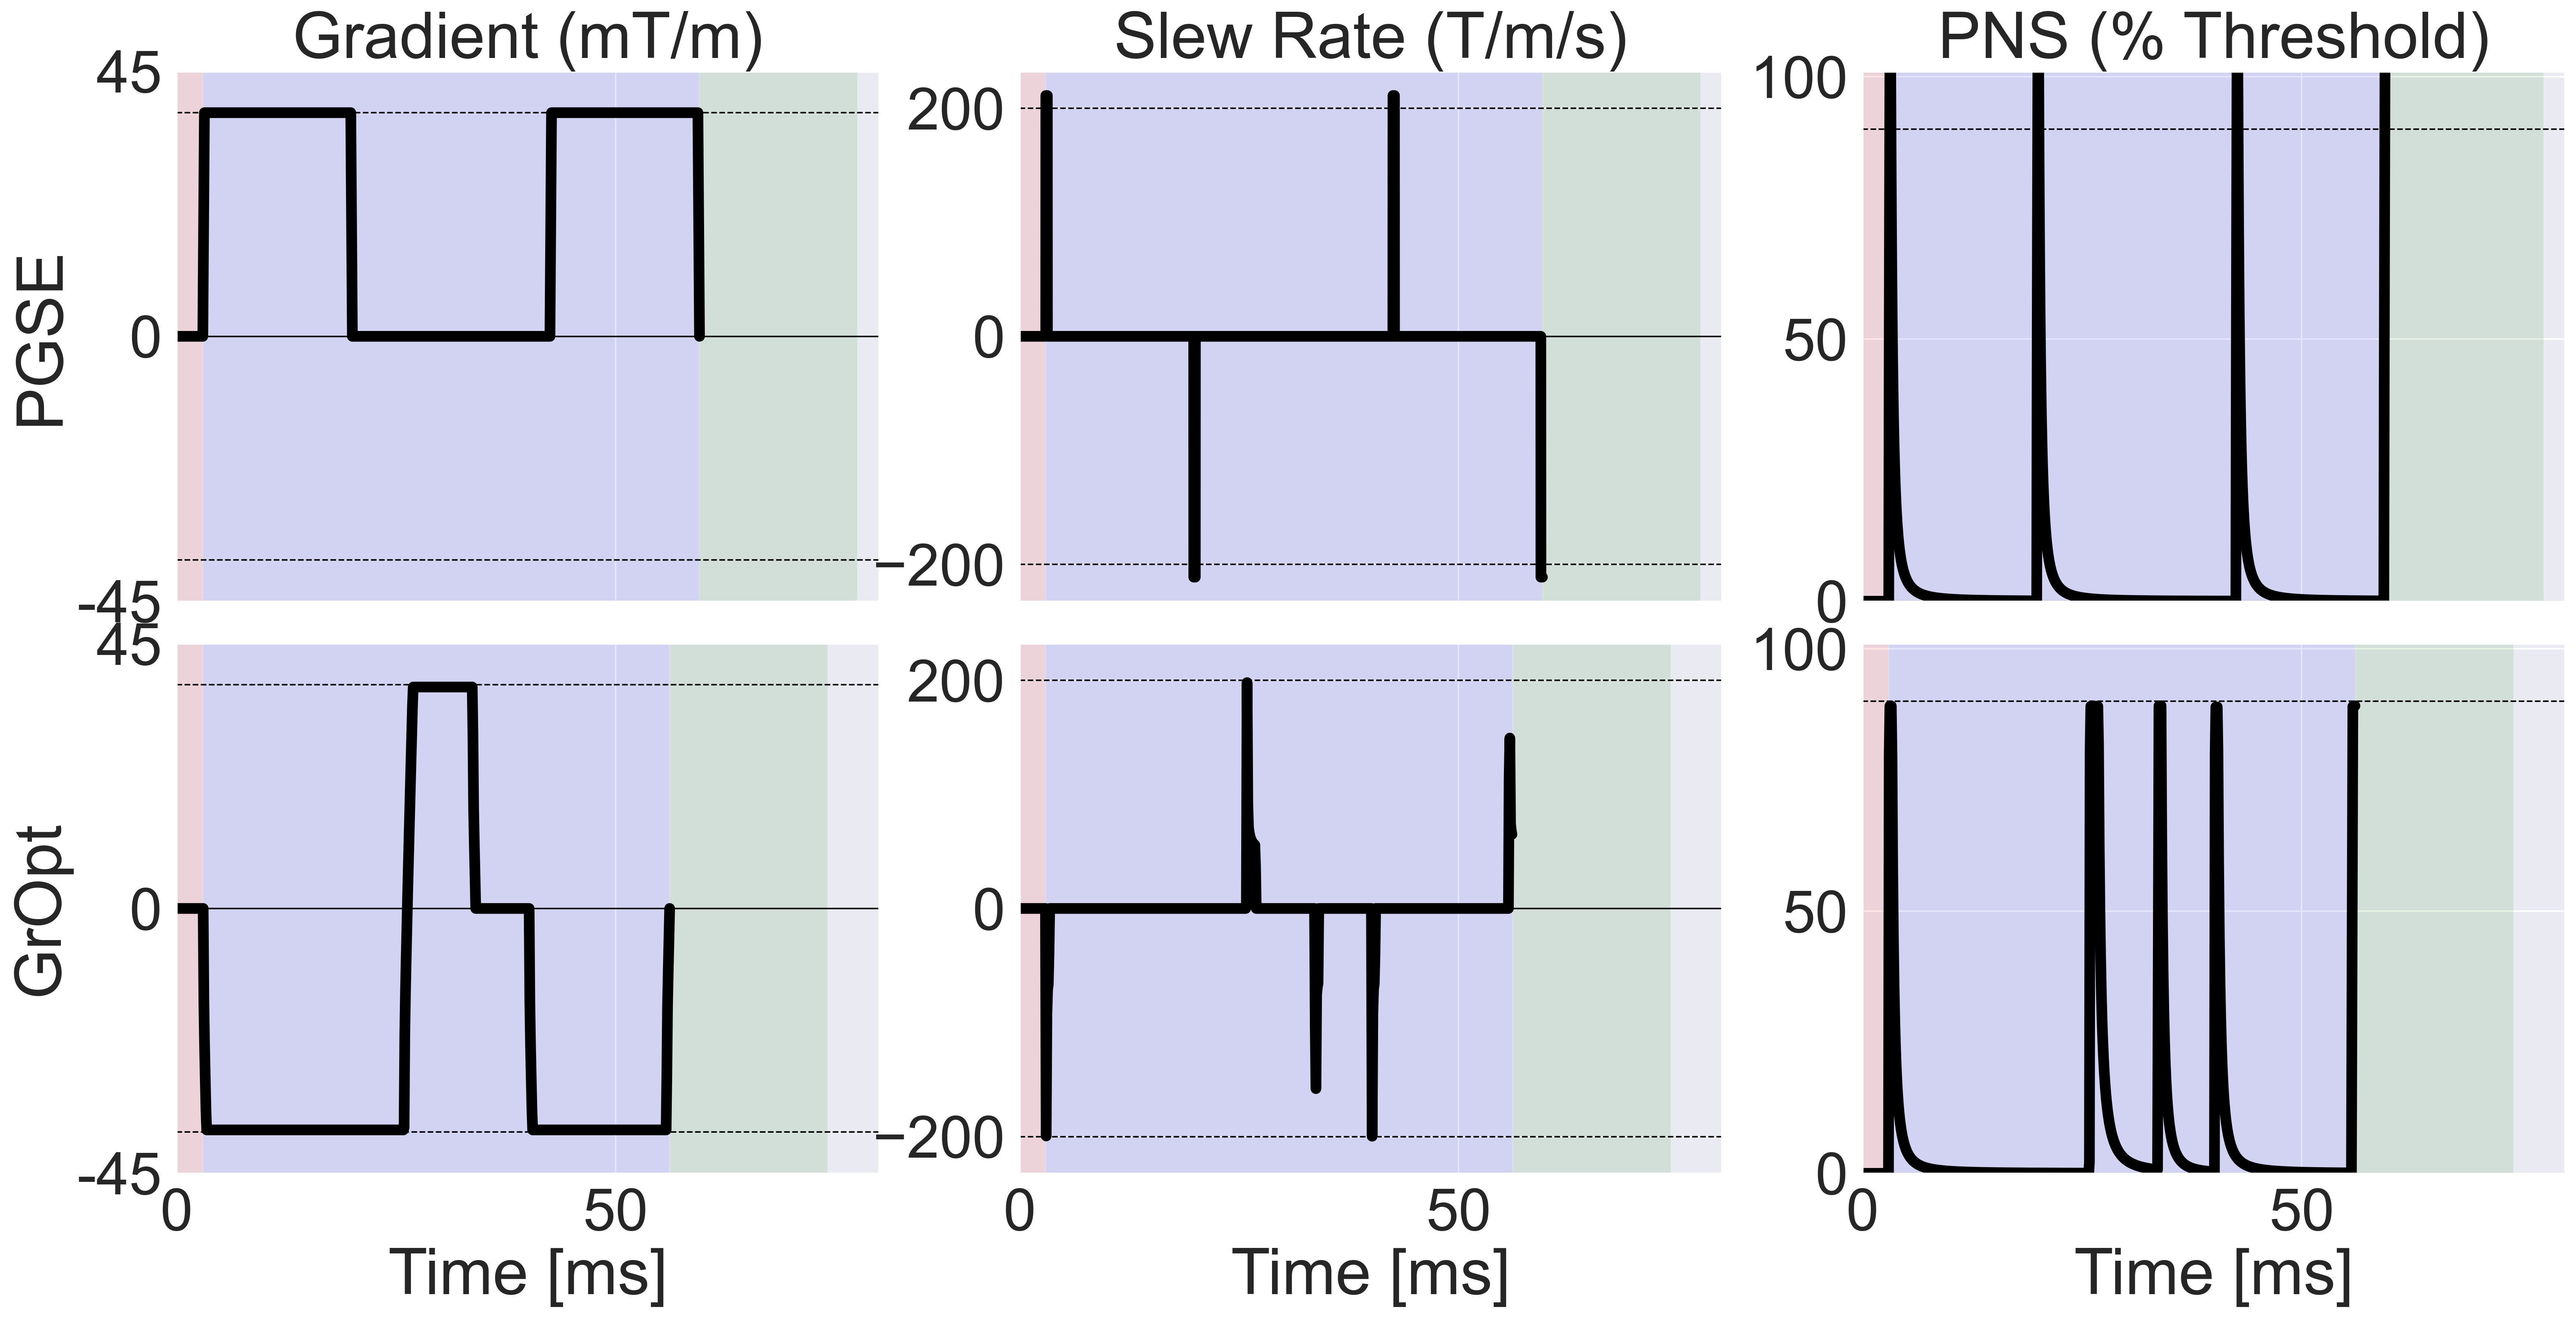

In [12]:
# 3. Visaulize the results
sns.set(font_scale=3.5) 
gropt_params['MMT'] = 0

colors = ['black','black','black']
fig, axes = plt.subplots(nrows=2, ncols=3,  sharex=True,sharey = 'col', figsize=(28, 13), dpi=300)
# Formatting 
for ii in range(2):
    for jj in range(3):
        axes[ii,jj].axhline(0,linewidth = 1,color = 'black',)

fig.patch.set_alpha(0) 

axes[1,0].axhline(gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[1,0].axhline(-gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[0,0].axhline(gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[0,0].axhline(-gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )

axes[1,1].axhline(gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[1,1].axhline(-gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[0,1].axhline(gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[0,1].axhline(-gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )

for jj in range(2):
    axes[jj,2].axhline(90, linewidth = 1,color='black',linestyle='--' )
    axes[jj,2].set_ylim([0,101])

for ii in range(1):
    axes[ii,0].set_title('Gradient (mT/m)')
    axes[ii,1].set_title('Slew Rate (T/m/s)')
    axes[ii,2].set_title('PNS (% Threshold)')



###########################################
# Plot First Gradient Pairs for the Premier Scanner System
# Plot the Gradients 

time_range = np.linspace(0, (grad_TRAP_m0.shape[0]-1) * input_params['dt'] * 1e3, grad_TRAP_m0 .shape[0])
axes[0,0].plot(time_range, grad_TRAP_m0*1e3,linewidth =7,color = colors[0], label = 'TE= {:.2f}ms'.format(TE_TRAP_m0))
axes[0,1].plot(time_range[:-1], np.diff(grad_TRAP_m0)/input_params['dt'],linewidth =7,color = colors[0])

for idx in range(3):
    axes[0,idx].axvspan(0,input_params['T_90'], facecolor='red', alpha=0.1,zorder = 1)
    axes[0,idx].axvspan(input_params['T_90'],time_range[-1], facecolor='blue', alpha=0.1,zorder = 1)
    axes[0,idx].axvspan(time_range[-1],time_range[-1]+input_params['T_readout'], facecolor='green', alpha=0.1,zorder = 1)
#axes[0,0].fill_between([time_range[-1],time_range[-1]+input_params['T_readout']],10,-10, color= 'gray', zorder = 1)
axes[0,0].set_xlim([0,100])

pns= np.abs(get_stim(grad_TRAP_m0[np.newaxis,:], input_params['dt'])) 
axes[0,2].plot(time_range[:-1],pns*100,linewidth =7,color = colors[0],label = 'TRAP')


time_range = np.linspace(0, (grad_GrOpt_m0.shape[1]-1) * gropt_params['dt'] * 1e3, grad_GrOpt_m0 .shape[1])
axes[1,0].plot(np.squeeze(time_range), np.squeeze(grad_GrOpt_m0)*1e3,linewidth =7,color = colors[1],zorder =2,label = 'TE= {:.2f}ms'.format(TE_GrOpt_m0))
axes[1,1].plot(time_range[:-1], np.diff(np.squeeze(grad_GrOpt_m0))/gropt_params['dt'],linewidth =7,color = colors[1])

for idx in range(3):
    axes[1,idx].axvspan(0,input_params['T_90'], facecolor='red', alpha=0.1,zorder = 1)
    axes[1,idx].axvspan(input_params['T_90'],time_range[-1], facecolor='blue', alpha=0.1,zorder = 1)
    axes[1,idx].axvspan(time_range[-1],time_range[-1]+input_params['T_readout'], facecolor='green', alpha=0.1,zorder = 1)
#axes[1,0].fill_between([time_range[-1],time_range[-1]+input_params['T_readout']],10,-10, color= 'gray', zorder = 1)

pns= np.abs(get_stim(grad_GrOpt_m0, gropt_params['dt'])) 
axes[1,2].plot(time_range[:-1],pns*100,linewidth =7,color = colors[1],label = 'GrOpt')


groptG = np.squeeze((grad_GrOpt_m0))
zero_crossings = np.where(np.diff(np.sign(groptG)))[0]
sums_between_zero_crossings = []
range_zero_crossings =[]

# Calculate the sums between zero crossings
for i in range(len(zero_crossings) - 1):
    start_idx = zero_crossings[i] + 1  # Start one index after the zero crossing
    end_idx = zero_crossings[i + 1]  # Up to the next zero crossing
    sum_values = np.sum(abs(groptG[start_idx:end_idx]))
    sums_between_zero_crossings.append(sum_values)
    range_zero_crossings.append([start_idx,end_idx])

index_closest_to_zero = np.argmin(np.abs(sums_between_zero_crossings))

start_idx = range_zero_crossings[index_closest_to_zero][0]
end_idx = range_zero_crossings[index_closest_to_zero][1]

start = (time_range)[start_idx]
end= (time_range)[end_idx]
midpoint = (start+end)/2
start_180 = midpoint - gropt_params['T_180']/2
x = np.arange(-3, 3, gropt_params['dt'])
# Calculate the truncated sinc function
y = np.sinc(x) 
# Set values outside the range to 0
y[x < -3] = 0
y[x > 3] = 0
x2 = np.linspace(start_180, start_180 + gropt_params['T_180'], int(gropt_params['T_180'] / gropt_params['dt']) + 1)

min_length = min(len(x2), len(y))
x2 = x2[:min_length]
y = y[:min_length]
#axes[1,0].plot(x2,y*80*0.3,linewidth =2, color='black')

# define yticklabels for first column as -45 0 45
yticks = np.arange(-45, 46, 45)
yticklabels = [str(int(tick)) for tick in yticks]
axes[0,0].set_yticks(yticks)
axes[0,0].set_yticklabels(yticklabels)
axes[1,0].set_yticks(yticks)
axes[1,0].set_yticklabels(yticklabels)


axes[0,0].set_ylabel('PGSE')
axes[1,0].set_ylabel('GrOpt')
#############################################################################################################


for ii in range(3):
    axes[-1,ii].set_xlabel('Time [ms]')


axes[0,0].set_xlim([0,80])
plt.subplots_adjust(wspace=0.2, hspace=0.08)  
plt.show()

fig.savefig('M0_Gmax45.svg')


# Example 2: System with Gmax = 200 mT/m and Smax = 200 T/m/s, M0 Moment Nulling


In [13]:
# Demo for 200/200 System
# 1. Load the system parameters
gmax = 200
system_smax = 180
input_params = {'T_90': 2.4,#,2.4000000000000004,
 'T_180': 5.3, #,
 'dt': 1e-05,
 'T_readout': 18,
 'b': 1000,
 'MMT': 0, # M1 moment nulling
 'pns_thresh': 0.9,
 'gmax': 150, # De-rate gradients so converges faster
 'smax': 70, # De-rate slew to converge faster, 
 'tol': 0.01,
 'mode': 'diff_bval'}



In [14]:
# 2. Create PGSE (Trap) waveforms and run optimization for GrOpt waveforms 
gropt_mode = True  # Flag to enable GrOpt (Gradient Optimization) waveform computation

# Set PNS (Peripheral Nerve Stimulation) threshold and gradient slew rate limit
input_params['pns_thresh'] = 3     # High threshold for initial TRAP waveform
pns_thresh = 3
lim = 0.005                        # Slew rate limit (T/m/s)

# Generate traditional PGSE (TRAP) gradient waveform and related outputs
G, Time, echoT, b, pns, _, _, _ = calc_trap(input_params.copy(), lim, pns_thresh)

# Update PNS threshold for GrOpt optimization (stricter constraint)
input_params['pns_thresh'] = 0.9
pns_thresh = 0.9

if gropt_mode:
    # Copy input parameters for GrOpt optimization
    gropt_params = input_params.copy()
    
    # Set TE to match TRAP echo time to ensure fair comparison
    input_params['TE'] = echoT

    # Update parameters for optimization
    gropt_params['dt'] = 8e-5               # Time resolution (s)
    gropt_params['smax'] = system_smax     # Use system's slew rate limit
    gropt_params['gmax'] = gmax            # Use system's max gradient amplitude

    # Match target b-value to that of TRAP
    target_b = b
    start_TE = echoT                       # Starting TE for optimization

    # Run GrOpt optimization to get minimum TE waveform for the same b-value
    G_gropt, TE = get_min_TE(gropt_params, verbose=True, bval=target_b)

    print(gropt_params)
    
    # Recalculate b-value for optimized waveform
    gropt_b = get_bval(G_gropt, gropt_params)

    print('Gropt TE: {:.5f} ms, Gropt Bval: {:.2f}'.format(gropt_params['TE'], gropt_b)) 

    # Compute PNS for optimized waveform
    pns_gropt = np.abs(get_stim(G_gropt, gropt_params['dt']))

    # Construct waveform name for saving/logging
    name = 'Waveform_b' + str(input_params['b']) + '_Res2.5_PNS' + \
        str(input_params['pns_thresh']) + '_MMT' + str(input_params['MMT'])

    # Print comparison of echo times
    print('Traditional TE: {:.2f} ms, Gropt TE: {:.5f} ms '.format(echoT, gropt_params['TE']))
    print('Difference:', 
          np.round((echoT - gropt_params['TE']), 2), 
          np.round(abs(echoT - gropt_params['TE']) / echoT * 100, 2))

    # Save final gradient waveforms and TEs
    grad_TRAP_m0 = G
    grad_GrOpt_m0 = G_gropt

    TE_TRAP_m0 = echoT
    TE_GrOpt_m0 = gropt_params['TE']

3828
0.002620000000000006
Testing TE = 117.850 76.775 56.238 45.969 51.103 48.536 49.820 49.178 48.857 48.696 48.616 48.656 48.676 48.686 Final TE = 48.686 ms
{'T_90': 2.4, 'T_180': 5.3, 'dt': 8e-05, 'T_readout': 18, 'b': 1000, 'MMT': 0, 'pns_thresh': 0.9, 'gmax': 200, 'smax': 180, 'tol': 0.01, 'mode': 'diff_bval', 'TE': 48.68635864257813}
Gropt TE: 48.68636 ms, Gropt Bval: 1014.69
Traditional TE: 56.31 ms, Gropt TE: 48.68636 ms 
Difference: 7.63 13.54


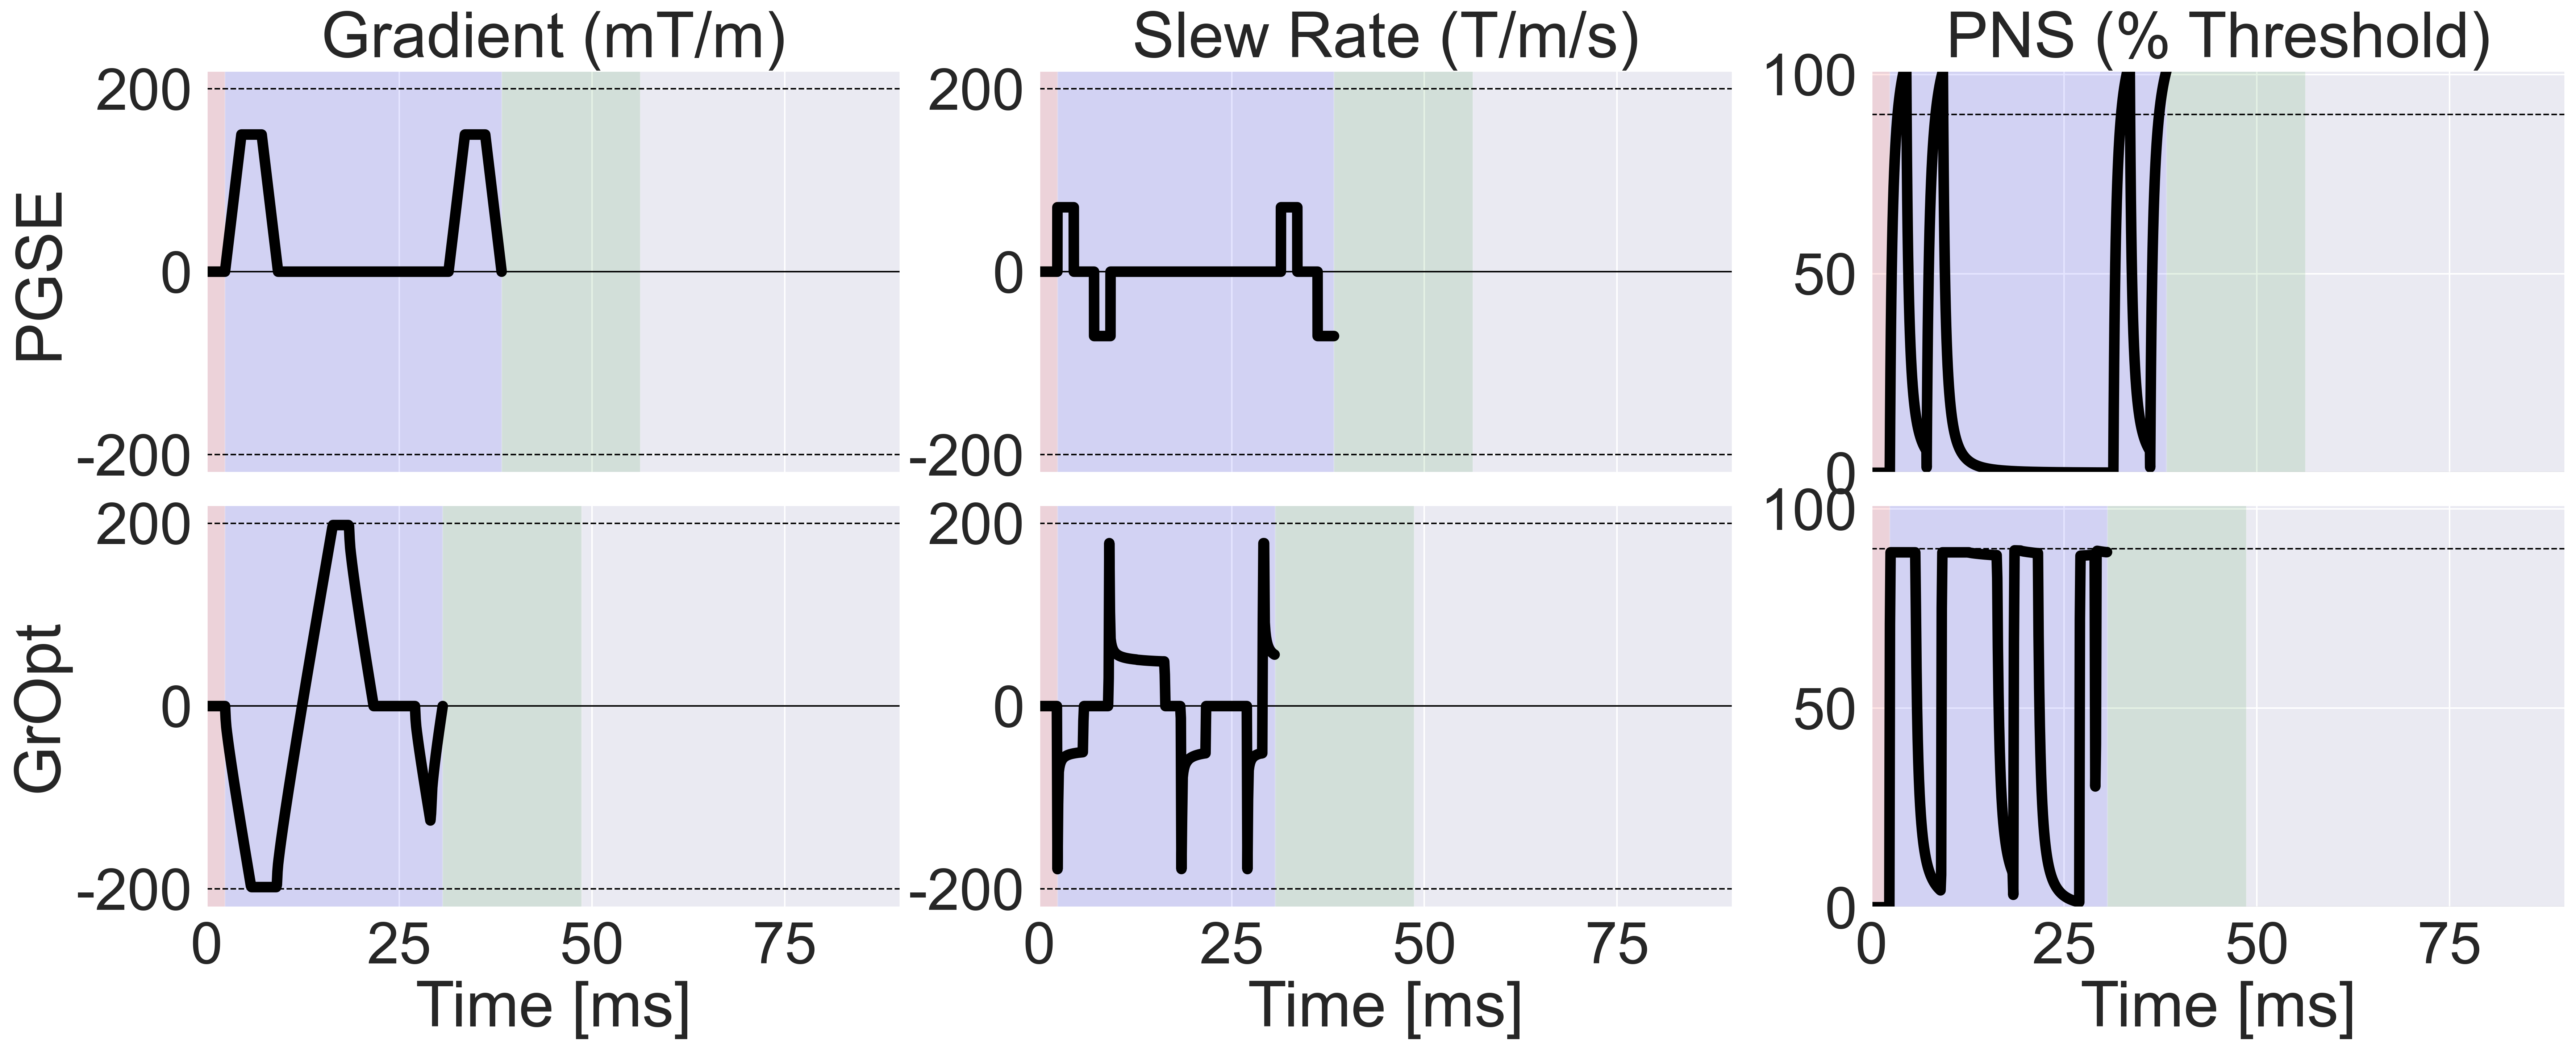

In [15]:
# 3. Visaulize the results
sns.set(font_scale=3.5) 
gropt_params['MMT'] = 0
gropt_params['smax'] = 200

colors = ['black','black','black']
fig, axes = plt.subplots(nrows=2, ncols=3,  sharex=True,sharey = 'col', figsize=(28, 10), dpi=300)
# Formatting 
for ii in range(2):
    for jj in range(3):
        axes[ii,jj].axhline(0,linewidth = 1,color = 'black',)

fig.patch.set_alpha(0) 

axes[1,0].axhline(gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[1,0].axhline(-gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[0,0].axhline(gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[0,0].axhline(-gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )

axes[1,1].axhline(gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[1,1].axhline(-gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[0,1].axhline(gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[0,1].axhline(-gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )

for jj in range(2):
    axes[jj,2].axhline(90, linewidth = 1,color='black',linestyle='--' )
    axes[jj,2].set_ylim([0,101])

for ii in range(1):
    axes[ii,0].set_title('Gradient (mT/m)')
    axes[ii,1].set_title('Slew Rate (T/m/s)')
    axes[ii,2].set_title('PNS (% Threshold)')



###########################################
# Plot First Gradient Pairs for the Premier Scanner System
# Plot the Gradients 

time_range = np.linspace(0, (grad_TRAP_m0.shape[0]-1) * input_params['dt'] * 1e3, grad_TRAP_m0 .shape[0])
axes[0,0].plot(time_range, grad_TRAP_m0*1e3,linewidth =7,color = colors[0], label = 'TE= {:.2f}ms'.format(TE_TRAP_m0))
axes[0,1].plot(time_range[:-1], np.diff(grad_TRAP_m0)/input_params['dt'],linewidth =7,color = colors[0])

for idx in range(3):
    axes[0,idx].axvspan(0,input_params['T_90'], facecolor='red', alpha=0.1,zorder = 1)
    axes[0,idx].axvspan(input_params['T_90'],time_range[-1], facecolor='blue', alpha=0.1,zorder = 1)
    axes[0,idx].axvspan(time_range[-1],time_range[-1]+input_params['T_readout'], facecolor='green', alpha=0.1,zorder = 1)
#axes[0,0].fill_between([time_range[-1],time_range[-1]+input_params['T_readout']],10,-10, color= 'gray', zorder = 1)
axes[0,0].set_xlim([0,120])

pns= np.abs(get_stim(grad_TRAP_m0[np.newaxis,:], input_params['dt'])) 
axes[0,2].plot(time_range[:-1],pns*100,linewidth =7,color = colors[0],label = 'TRAP')


time_range = np.linspace(0, (grad_GrOpt_m0.shape[1]-1) * gropt_params['dt'] * 1e3, grad_GrOpt_m0 .shape[1])
axes[1,0].plot(np.squeeze(time_range), np.squeeze(grad_GrOpt_m0)*1e3,linewidth =7,color = colors[1],zorder =2,label = 'TE= {:.2f}ms'.format(TE_GrOpt_m0))
axes[1,1].plot(time_range[:-1], np.diff(np.squeeze(grad_GrOpt_m0))/gropt_params['dt'],linewidth =7,color = colors[1])

for idx in range(3):
    axes[1,idx].axvspan(0,input_params['T_90'], facecolor='red', alpha=0.1,zorder = 1)
    axes[1,idx].axvspan(input_params['T_90'],time_range[-1], facecolor='blue', alpha=0.1,zorder = 1)
    axes[1,idx].axvspan(time_range[-1],time_range[-1]+input_params['T_readout'], facecolor='green', alpha=0.1,zorder = 1)
#axes[1,0].fill_between([time_range[-1],time_range[-1]+input_params['T_readout']],10,-10, color= 'gray', zorder = 1)

pns= np.abs(get_stim(grad_GrOpt_m0, gropt_params['dt'])) 
axes[1,2].plot(time_range[:-1],pns*100,linewidth =7,color = colors[1],label = 'GrOpt')


groptG = np.squeeze((grad_GrOpt_m0))
zero_crossings = np.where(np.diff(np.sign(groptG)))[0]
sums_between_zero_crossings = []
range_zero_crossings =[]

# Calculate the sums between zero crossings
for i in range(len(zero_crossings) - 1):
    start_idx = zero_crossings[i] + 1  # Start one index after the zero crossing
    end_idx = zero_crossings[i + 1]  # Up to the next zero crossing
    sum_values = np.sum(abs(groptG[start_idx:end_idx]))
    sums_between_zero_crossings.append(sum_values)
    range_zero_crossings.append([start_idx,end_idx])

index_closest_to_zero = np.argmin(np.abs(sums_between_zero_crossings))

start_idx = range_zero_crossings[index_closest_to_zero][0]
end_idx = range_zero_crossings[index_closest_to_zero][1]

start = (time_range)[start_idx]
end= (time_range)[end_idx]
midpoint = (start+end)/2
start_180 = midpoint - gropt_params['T_180']/2
x = np.arange(-3, 3, gropt_params['dt'])
# Calculate the truncated sinc function
y = np.sinc(x) 
# Set values outside the range to 0
y[x < -3] = 0
y[x > 3] = 0
x2 = np.linspace(start_180, start_180 + gropt_params['T_180'], int(gropt_params['T_180'] / gropt_params['dt']) + 1)

min_length = min(len(x2), len(y))
x2 = x2[:min_length]
y = y[:min_length]
#axes[1,0].plot(x2,y*80*0.3,linewidth =2, color='black')

# define yticklabels for first column as -45 0 45
yticks = np.arange(-200, 201, 200)
yticklabels = [str(int(tick)) for tick in yticks]
axes[0,0].set_yticks(yticks)
axes[0,0].set_yticklabels(yticklabels)
axes[1,0].set_yticks(yticks)
axes[1,0].set_yticklabels(yticklabels)

axes[0,0].set_ylabel('PGSE')
axes[1,0].set_ylabel('GrOpt')

axes[0,1].set_yticks(yticks)
axes[0,1].set_yticklabels(yticklabels)

#############################################################################################################


for ii in range(3):
    axes[-1,ii].set_xlabel('Time [ms]')

xticks = np.arange(0, 100, 25)
axes[0,-1].set_xticks(xticks)

axes[0,0].set_xlim([0,90])
plt.subplots_adjust(wspace=0.2, hspace=0.08)  
plt.show()

fig.savefig('M0_Gmax200.svg')


# Example 3: System with Gmax = 200 mT/m and Smax = 200 T/m/s, M0+M1 Moment nulling

In [16]:
# Demo for 200/200 System, M1
# 1. Load the system parameters
gmax = 200
system_smax = 180
input_params = {'T_90': 2.4,#,2.4000000000000004,
 'T_180': 5.3, #,
 'dt': 1e-05,
 'T_readout': 18,
 'b': 1000,
 'MMT': 1, # M1 moment nulling
 'pns_thresh': 0.9,
 'gmax': 150, # De-rate gradients so converges faster
 'smax': 70, # De-rate slew to converge faster, 
 'tol': 0.01,
 'mode': 'diff_bval'}



In [17]:
# 2. Create PGSE (trap) waveforms and run optimization for GrOpt waveforms 
gropt_mode = True

input_params['pns_thresh'] = 0.9#0.8
pns_thresh = 0.9#0.8
lim = 0.005

G,Time,echoT,b,pns,_,_,_ = calc_trap(input_params.copy(),lim,pns_thresh)
#print('Traditional TE: {:.2f} ms, Computed B-val: {:.2f}, PNS: {:.2f}'.format(echoT,b,np.nanmax(pns))) 


if gropt_mode:
    gropt_params = input_params.copy()
    input_params['TE'] = echoT
    gropt_params['dt'] = 8e-5
    gropt_params['smax'] = system_smax # reset to system limits 
    gropt_params['gmax'] = gmax # reset to true system limits

    target_b = b
    start_TE = echoT

    #gropt_params, G_gropt, te_track, b_track =calc_grop_hybrid(gropt_params.copy(), input_params['b'], start_TE,  0.001,iterations=25,)
    G_gropt, TE =  get_min_TE(gropt_params,verbose = True, bval =target_b)

    print(gropt_params)
    gropt_b = get_bval(G_gropt, gropt_params)
    print('Gropt TE: {:.5f} ms, Gropt Bval: {:.2f}'.format(gropt_params['TE'],gropt_b, )) 
    pns_gropt= np.abs(get_stim(G_gropt, gropt_params['dt'])) 

    name = 'Waveform_b'+str(input_params['b']) + '_Res2.5_PNS' +\
        str(input_params['pns_thresh']) + '_MMT' + str(input_params['MMT'])

    #plot_waveforms(input_params,gropt_params, G_gropt, Time, G, pns, pns_gropt,name)
    print('Traditional TE: {:.2f} ms,Gropt TE: {:.5f} ms '.format(echoT,gropt_params['TE']))
    print('Difference:', np.round((echoT- gropt_params['TE']),2), np.round(abs(echoT- gropt_params['TE'])/echoT*100,2))



    grad_TRAP_m0 = G
    grad_GrOpt_m0 = G_gropt

    TE_TRAP_m0 = echoT
    TE_GrOpt_m0 = gropt_params['TE']

6044
0.004719999999999976
	PNS above thresh,pns at 1.0977428989924038
6053
	PNS is 1.08
	PNS above thresh,pns at 1.0835362147137495
6061
	PNS is 1.07
	PNS above thresh,pns at 1.069691951843998
6069
	PNS is 1.06
	PNS above thresh,pns at 1.0561964372913104
6077
	PNS is 1.04
	PNS above thresh,pns at 1.0387127960783307
6085
	PNS is 1.03
	PNS above thresh,pns at 1.0259816816530867
6097
	PNS is 1.01
	PNS above thresh,pns at 1.0094885836885006
6109
	PNS is 0.99
	PNS above thresh,pns at 0.9935167955655445
6117
	PNS is 0.98
	PNS above thresh,pns at 0.9818618959045676
6125
	PNS is 0.97
	PNS above thresh,pns at 0.9667310607566515
6137
	PNS is 0.95
	PNS above thresh,pns at 0.952072227620888
6149
	PNS is 0.93
	PNS above thresh,pns at 0.9343515834183236
6161
	PNS is 0.92
	PNS above thresh,pns at 0.9206503366911372
6173
	PNS is 0.9
	PNS above thresh,pns at 0.9040684403681323
6185
	PNS is 0.89
Testing TE = 117.850 76.775 56.238 45.969 51.103 53.670 54.954 55.596 55.275 55.114 55.195 55.235 55.255 55.2

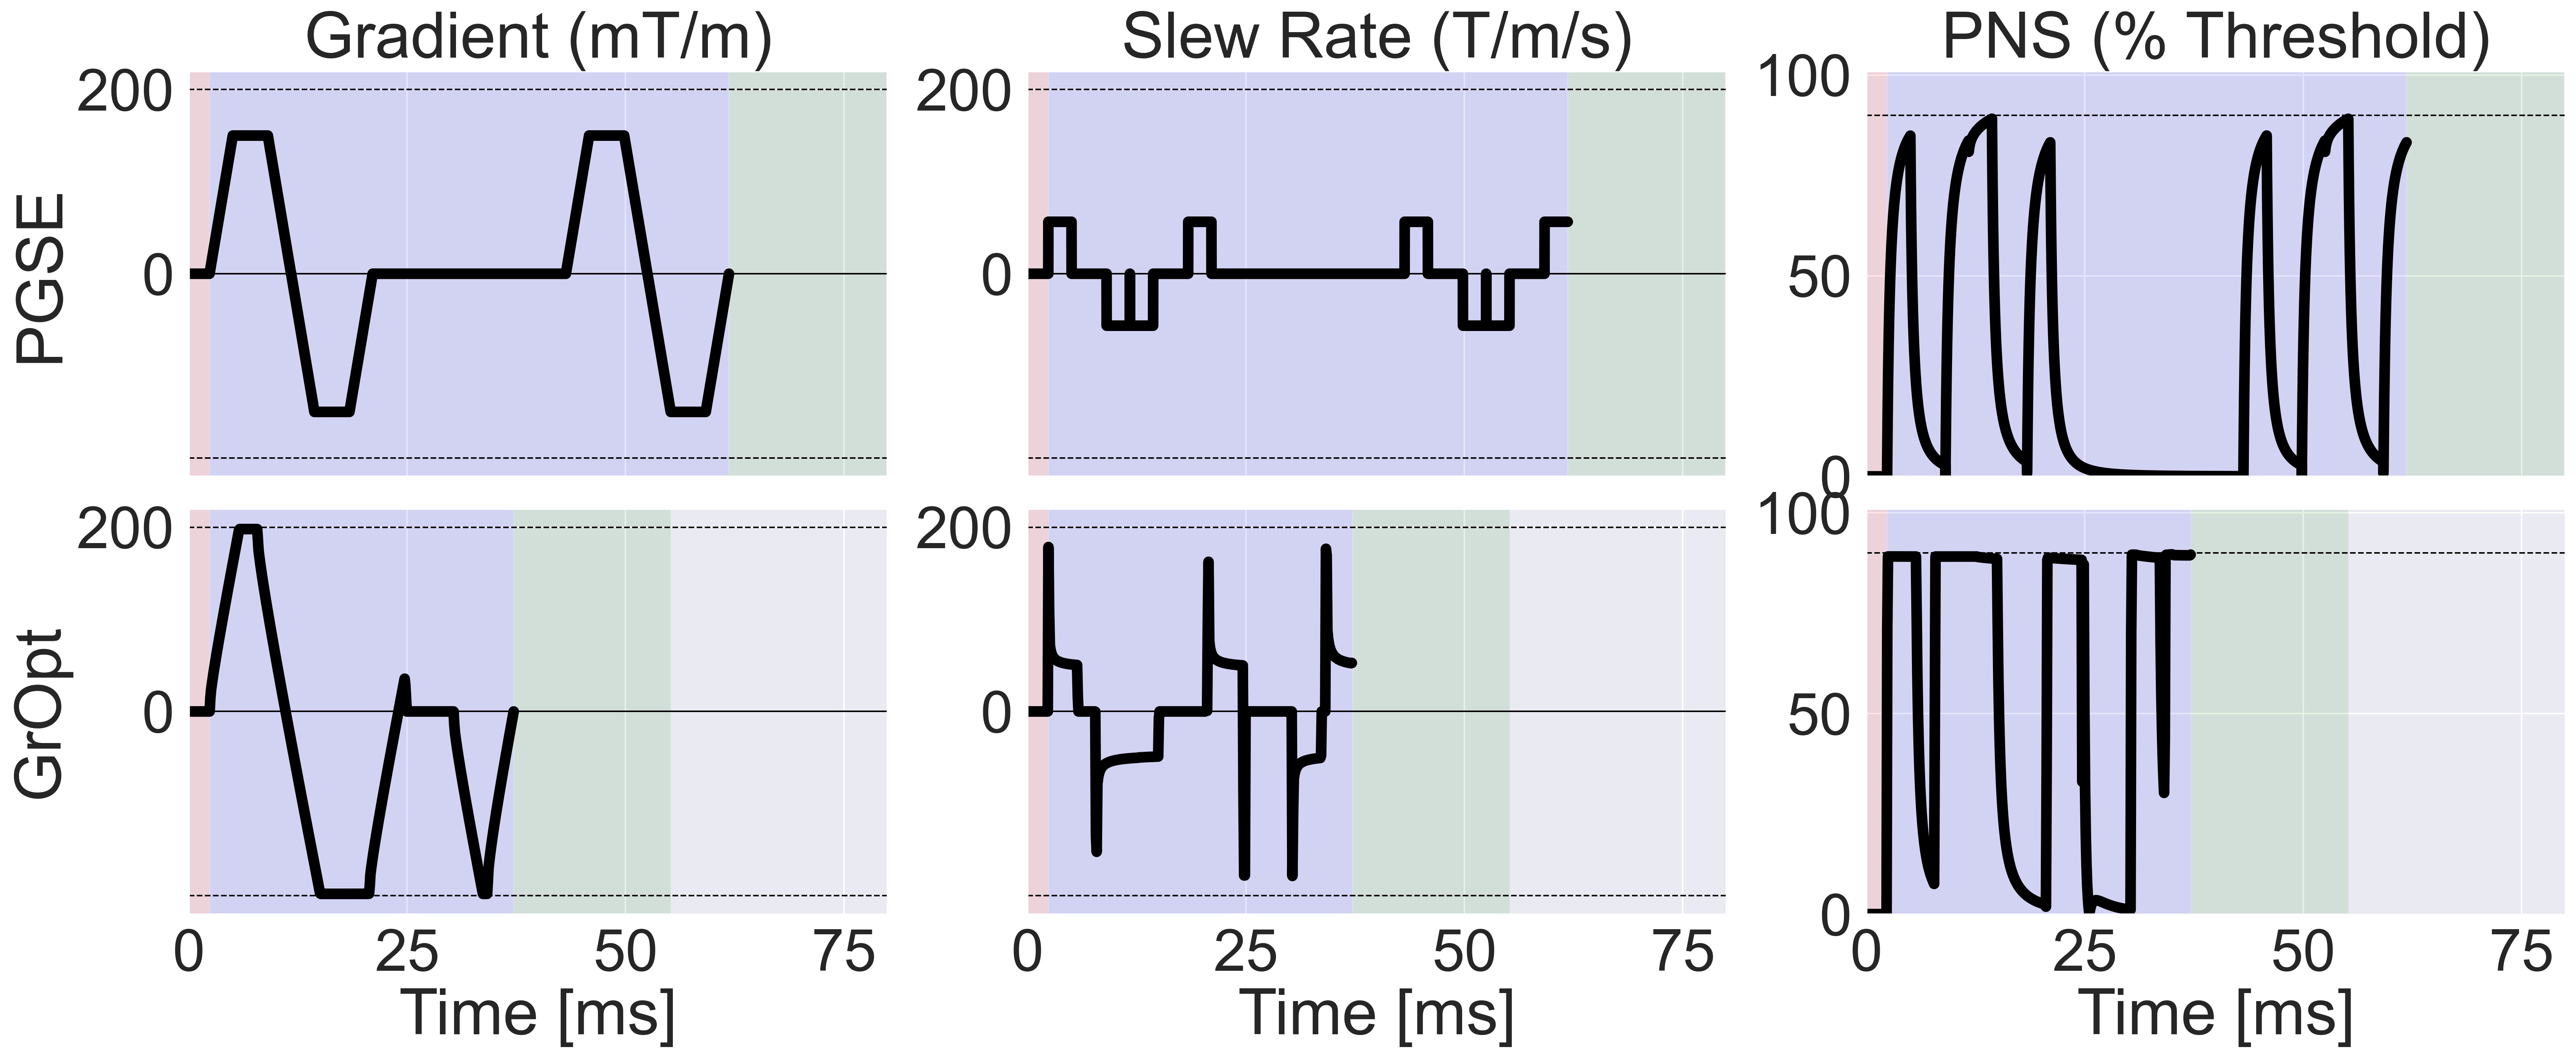

In [18]:
# 3. Visaulize the results
sns.set(font_scale=3.5) 
gropt_params['MMT'] = 0
gropt_params['smax'] = 200

colors = ['black','black','black']
fig, axes = plt.subplots(nrows=2, ncols=3,  sharex=True,sharey = 'col', figsize=(28, 10), dpi=300)
# Formatting 
for ii in range(2):
    for jj in range(3):
        axes[ii,jj].axhline(0,linewidth = 1,color = 'black',)

fig.patch.set_alpha(0) 

axes[1,0].axhline(gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[1,0].axhline(-gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[0,0].axhline(gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )
axes[0,0].axhline(-gropt_params['gmax'], linewidth = 1,color='black',linestyle='--' )

axes[1,1].axhline(gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[1,1].axhline(-gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[0,1].axhline(gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )
axes[0,1].axhline(-gropt_params['smax'], linewidth = 1,color='black',linestyle='--' )

for jj in range(2):
    axes[jj,2].axhline(90, linewidth = 1,color='black',linestyle='--' )
    axes[jj,2].set_ylim([0,101])

for ii in range(1):
    axes[ii,0].set_title('Gradient (mT/m)')
    axes[ii,1].set_title('Slew Rate (T/m/s)')
    axes[ii,2].set_title('PNS (% Threshold)')



###########################################
# Plot First Gradient Pairs for the Premier Scanner System
# Plot the Gradients 

time_range = np.linspace(0, (grad_TRAP_m0.shape[0]-1) * input_params['dt'] * 1e3, grad_TRAP_m0 .shape[0])
axes[0,0].plot(time_range, grad_TRAP_m0*1e3,linewidth =7,color = colors[0], label = 'TE= {:.2f}ms'.format(TE_TRAP_m0))
axes[0,1].plot(time_range[:-1], np.diff(grad_TRAP_m0)/input_params['dt'],linewidth =7,color = colors[0])

for idx in range(3):
    axes[0,idx].axvspan(0,input_params['T_90'], facecolor='red', alpha=0.1,zorder = 1)
    axes[0,idx].axvspan(input_params['T_90'],time_range[-1], facecolor='blue', alpha=0.1,zorder = 1)
    axes[0,idx].axvspan(time_range[-1],time_range[-1]+input_params['T_readout'], facecolor='green', alpha=0.1,zorder = 1)
#axes[0,0].fill_between([time_range[-1],time_range[-1]+input_params['T_readout']],10,-10, color= 'gray', zorder = 1)
axes[0,0].set_xlim([0,120])

pns= np.abs(get_stim(grad_TRAP_m0[np.newaxis,:], input_params['dt'])) 
axes[0,2].plot(time_range[:-1],pns*100,linewidth =7,color = colors[0],label = 'TRAP')


time_range = np.linspace(0, (grad_GrOpt_m0.shape[1]-1) * gropt_params['dt'] * 1e3, grad_GrOpt_m0 .shape[1])
axes[1,0].plot(np.squeeze(time_range), np.squeeze(grad_GrOpt_m0)*1e3,linewidth =7,color = colors[1],zorder =2,label = 'TE= {:.2f}ms'.format(TE_GrOpt_m0))
axes[1,1].plot(time_range[:-1], np.diff(np.squeeze(grad_GrOpt_m0))/gropt_params['dt'],linewidth =7,color = colors[1])

for idx in range(3):
    axes[1,idx].axvspan(0,input_params['T_90'], facecolor='red', alpha=0.1,zorder = 1)
    axes[1,idx].axvspan(input_params['T_90'],time_range[-1], facecolor='blue', alpha=0.1,zorder = 1)
    axes[1,idx].axvspan(time_range[-1],time_range[-1]+input_params['T_readout'], facecolor='green', alpha=0.1,zorder = 1)
#axes[1,0].fill_between([time_range[-1],time_range[-1]+input_params['T_readout']],10,-10, color= 'gray', zorder = 1)

pns= np.abs(get_stim(grad_GrOpt_m0, gropt_params['dt'])) 
axes[1,2].plot(time_range[:-1],pns*100,linewidth =7,color = colors[1],label = 'GrOpt')


groptG = np.squeeze((grad_GrOpt_m0))
zero_crossings = np.where(np.diff(np.sign(groptG)))[0]
sums_between_zero_crossings = []
range_zero_crossings =[]

# Calculate the sums between zero crossings
for i in range(len(zero_crossings) - 1):
    start_idx = zero_crossings[i] + 1  # Start one index after the zero crossing
    end_idx = zero_crossings[i + 1]  # Up to the next zero crossing
    sum_values = np.sum(abs(groptG[start_idx:end_idx]))
    sums_between_zero_crossings.append(sum_values)
    range_zero_crossings.append([start_idx,end_idx])

index_closest_to_zero = np.argmin(np.abs(sums_between_zero_crossings))

start_idx = range_zero_crossings[index_closest_to_zero][0]
end_idx = range_zero_crossings[index_closest_to_zero][1]

start = (time_range)[start_idx]
end= (time_range)[end_idx]
midpoint = (start+end)/2
start_180 = midpoint - gropt_params['T_180']/2
x = np.arange(-3, 3, gropt_params['dt'])
# Calculate the truncated sinc function
y = np.sinc(x) 
# Set values outside the range to 0
y[x < -3] = 0
y[x > 3] = 0
x2 = np.linspace(start_180, start_180 + gropt_params['T_180'], int(gropt_params['T_180'] / gropt_params['dt']) + 1)

min_length = min(len(x2), len(y))
x2 = x2[:min_length]
y = y[:min_length]
#axes[1,0].plot(x2,y*80*0.3,linewidth =2, color='black')

# define yticklabels for first column as -45 0 45
yticks = np.arange(0, 201, 200)
yticklabels = [str(int(tick)) for tick in yticks]
axes[0,0].set_yticks(yticks)
axes[0,0].set_yticklabels(yticklabels)
axes[1,0].set_yticks(yticks)
axes[1,0].set_yticklabels(yticklabels)

axes[0,0].set_ylabel('PGSE')
axes[1,0].set_ylabel('GrOpt')

axes[0,1].set_yticks(yticks)
axes[0,1].set_yticklabels(yticklabels)

#############################################################################################################


for ii in range(3):
    axes[-1,ii].set_xlabel('Time [ms]')

xticks = np.arange(0, 100, 25)
axes[0,-1].set_xticks(xticks)


axes[0,0].set_xlim([0,80])
plt.subplots_adjust(wspace=0.2, hspace=0.08)  
plt.show()

fig.savefig('M1_Gmax200.svg')


In [19]:
xticks

array([ 0, 25, 50, 75])